In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!git clone https://github.com/naufalhisyam/TurbidityPrediction-thesis.git
os.chdir('/content/TurbidityPrediction-thesis') 

Cloning into 'TurbidityPrediction-thesis'...
remote: Enumerating objects: 3105, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 3105 (delta 30), reused 95 (delta 16), pack-reused 2990
Receiving objects: 100% (3105/3105), 674.30 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (159/159), done.
Checking out files: 100% (3462/3462), done.


**Loading Model**

In [4]:
arch = 'ResNet'
name = 'ResNet_0deg_withTL'
degree = '0'

model_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/lowrange/{arch}/{name}"

In [5]:
def get_model(arch='DenseNet'):
    #Create model
    if arch=='ResNet':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, 
                                                    input_shape=(224, 224, 3), pooling='avg')
        out = base_model.output
        prediction = tf.keras.layers.Dense(1, activation="linear")(out)
        model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    else:
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights=None, 
                                                       input_shape=(224, 224, 3), pooling='avg')
        out = base_model.output
        prediction = tf.keras.layers.Dense(1, activation="linear")(out)
        model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    
    return model

In [6]:
model = get_model(arch)
model.load_weights(f"{model_path}/{arch}.h5")
opt = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

**Preparing Dataset**

In [7]:
def get_images(degree='0'):
    if degree == '90':
        images = pd.read_csv(r'./Datasets/90degree_val/90degInfo.csv') #load dataset info
        images2 = pd.read_csv(r'./Datasets/90degree_lowrange/90degInfo.csv') #load dataset info
        train_df, test_df = train_test_split(images2, train_size=0.9, shuffle=True, random_state=1)
    else:
        images = pd.read_csv(r'./Datasets/0degree_val/0degInfo.csv') #load dataset info
        images2 = pd.read_csv(r'./Datasets/0degree_lowrange/0degInfo.csv') #load dataset info
        train_df, test_df = train_test_split(images2, train_size=0.9, shuffle=True, random_state=1)
    
    return images, train_df, test_df

In [8]:
images, train_df, test_df = get_images(degree)
img_generator = tf.keras.preprocessing.image.ImageDataGenerator()

val_images = img_generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

train_images = img_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

test_images = img_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 25 validated image filenames.


In [9]:
pred = np.squeeze(model.predict(val_images))
true = val_images.labels
residuals = true - pred

score = model.evaluate(val_images)


test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

train_score = model.evaluate(train_images)
test_score = model.evaluate(test_images)
print('sampel air score  ',score)
print('test  ',test_score)
print('train  ', train_score)

1/1 [==============================] - 3s 3s/step - loss: 6.8771 - mae: 7.3128 - mse: 93.4637 - R2: 0.7040
score   [6.877111434936523, 7.312805652618408, 93.46371459960938, 0.7040242552757263]


In [ ]:
predicted = pd.Series(pred)
truevalue = pd.Series(true)
frame = { 'Predicted': predicted, 'True Val': truevalue }
result = pd.DataFrame(frame)
rslt_df = result.sort_values(by = 'True Val')
rslt_df

In [ ]:
test_predicted = pd.Series(test_pred)
test_truevalue = pd.Series(test_true)
testframe = { 'Predicted': test_predicted, 'True Val': test_truevalue }
testresult = pd.DataFrame(testframe)
test_rslt_df = testresult.sort_values(by = 'True Val')
test_rslt_df

In [ ]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test
shap_test = shapiro(test_residuals)
shap_train = shapiro(train_residuals)
shap_air = shapiro(residuals)

print('test', shap_test)
print('train', shap_train)
print('air', shap_air)

**Plotting Model Graphs**

Residual Plot

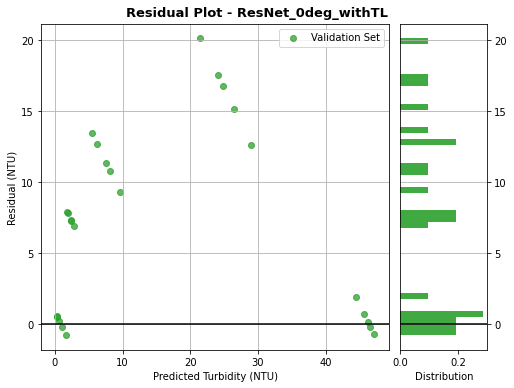

In [10]:
if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})

f.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold',  y=0.92) 
axs[0].scatter(pred,residuals, label='Validation Set', alpha=0.75, color='tab:green')   
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(residuals, bins=50, orientation="horizontal", density=True, alpha=0.9, color='tab:green')
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'plots/{name}/residualPlot_{name}.png', dpi=150)
plt.show()

Measured vs Predicted Plot

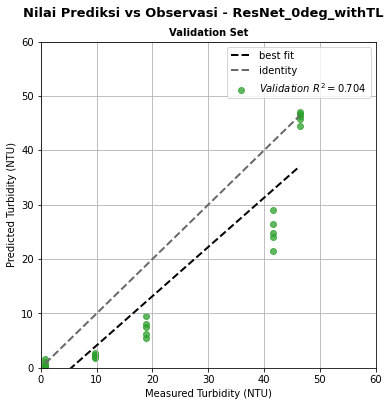

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

amax = pred.max()
delt = abs(true.max() - amax) + 2

ax.scatter(true,pred, label=f'Validation Set',color='tab:green', alpha=0.75)
theta = np.polyfit(true, pred, 1)
y_line = theta[1] + theta[0] * true
#ax.plot([true.min(), true.max()+delt], [y_line.min(), y_line.max()+delt],'k--', lw=2,label='best fit')
ax.plot([0,amax+2], [0,amax+2], 'k--', lw=2, label='identity',color='dimgray')
ax.set_xlabel('Measured Turbidity (NTU)')
ax.set_ylabel('Predicted Turbidity (NTU)')
ax.set_title(f'Test Set', fontsize=10, fontweight='bold')
ax.set_xlim([0,amax+2])
ax.set_ylim([0,amax+2])
ax.grid()
ax.legend()

plt.savefig(f'plots/{name}/predErrorPlot_{name}.png', dpi=150)
plt.show()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})

f.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold',  y=0.92) 
axs[0].scatter(train_pred,train_residuals, label='Train Set', alpha=0.75, color='tab:blue')   
axs[0].scatter(test_pred,test_residuals, label='Test Set', alpha=0.75, color='tab:orange')
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=50, orientation="horizontal", density=True, alpha=0.9, color='tab:blue')
axs[1].hist(test_residuals, bins=50, orientation="horizontal", density=True, alpha=0.75, color='tab:orange')
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'plots/{name}/trainresidualPlot_{name}.png', dpi=150)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(13,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

ax[0].scatter(test_true,test_pred, label=f'Test Set',color='tab:orange', alpha=0.75)
theta = np.polyfit(test_true, test_pred, 1)
y_line = theta[1] + theta[0] * test_true
ax[0].plot([test_true.min(), test_true.max()], [y_line.min(), y_line.max()],'k--', lw=2,label='best fit')
ax[0].plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[0].set_xlabel('Measured Turbidity (NTU)')
ax[0].set_ylabel('Predicted Turbidity (NTU)')
ax[0].set_title(f'Test Set', fontsize=10, fontweight='bold')
ax[0].set_xlim([0, 130])
ax[0].set_ylim([0, 130])
ax[0].grid()
ax[0].legend()

ax[1].scatter(train_true,train_pred, label=f'Train Set', color='tab:blue', alpha=0.75)
theta2 = np.polyfit(train_true, train_pred, 1)
y_line2 = theta2[1] + theta2[0] * train_true
ax[1].plot([train_true.min(), train_true.max()], [y_line2.min(), y_line2.max()],'k--', lw=2,label='best fit')
ax[1].plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[1].set_xlabel('Measured Turbidity (NTU)')
ax[1].set_ylabel('Predicted Turbidity (NTU)')
ax[1].set_title(f'Train Set', fontsize=10, fontweight='bold')
ax[1].set_xlim([0, 130])
ax[1].set_ylim([0, 130])
ax[1].grid()
ax[1].legend()

plt.savefig(f'plots/{name}/trainpredErrorPlot_{name}.png', dpi=150)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

ax.scatter(test_true,test_pred, label=f'Test Set',color='tab:orange', alpha=0.75)
ax.scatter(train_true,train_pred, label=f'Train Set', color='tab:blue', alpha=0.75)
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax.set_xlabel('Measured Turbidity (NTU)')
ax.set_ylabel('Predicted Turbidity (NTU)')
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()

plt.savefig(f'plots/{name}/trainpredErrorPlotgabung_{name}.png', dpi=150)
plt.show()

In [ ]:
rslt_csv_file = f'plots/{name}/val_result.csv'
with open(rslt_csv_file, mode='w') as f:
    rslt_df.to_csv(f)
    
test_rslt_csv_file = f'plots/{name}/test_result.csv'
with open(test_rslt_csv_file, mode='w') as f:
    test_rslt_df.to_csv(f)

In [12]:
save_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/Validation_Plots_REVISI"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "plots/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive
print("Done!")

Done!
